In [1]:
from typing import Optional, Literal
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


import datetime

from scipy.stats import normaltest

In [2]:
building_data = pd.read_csv('U://DATA/OpenClassrooms/Data science/P4/2016_Building_Energy_Benchmarking.csv')
building_data.shape

(3376, 46)

---------------------------------------------
Remove all data we don't need for the project and information we would not be able to get before the building is up and running

---------------------------------------------

In [3]:
# on check le pourcentage de remplissage des colonnes
columns_nan_info ={}
for column in building_data.keys():
    nan_count = building_data[column].isnull().sum()
    columns_nan_info[column] = nan_count / building_data.shape[0] * 100

df_columns_nan_info = pd.DataFrame(data=np.array(list(columns_nan_info.items())),columns=['column','nan %'])
df_columns_nan_info['nan %'] = pd.to_numeric(df_columns_nan_info['nan %'])
df_columns_nan_info = df_columns_nan_info.sort_values(by=['nan %'])

print(df_columns_nan_info.shape)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df_columns_nan_info)

(46, 2)
                             column       nan %
0                     OSEBuildingID    0.000000
19           PropertyGFABuilding(s)    0.000000
18               PropertyGFAParking    0.000000
17                 PropertyGFATotal    0.000000
16                   NumberofFloors    0.000000
14                        YearBuilt    0.000000
13                        Longitude    0.000000
12                         Latitude    0.000000
11                     Neighborhood    0.000000
40                      DefaultData    0.000000
10              CouncilDistrictCode    0.000000
42                 ComplianceStatus    0.000000
7                             State    0.000000
6                              City    0.000000
5                           Address    0.000000
4                      PropertyName    0.000000
3               PrimaryPropertyType    0.000000
2                      BuildingType    0.000000
1                          DataYear    0.000000
9     TaxParcelIdentificationNum

In [4]:
#Drop YearsENERGYSTARCertified, Comments and Outliers after deleting the lines marked as Outliers

building_data = building_data.drop(columns=['YearsENERGYSTARCertified', 'Comments'])
print(building_data.shape)

building_data = building_data[building_data['Outlier'].isnull()]
building_data = building_data.drop(columns=['Outlier'])
print(building_data.shape)

(3376, 44)
(3344, 43)


In [5]:
building_data['ComplianceStatus'].value_counts()

Compliant                       3211
Error - Correct Default Data     111
Missing Data                      15
Non-Compliant                      7
Name: ComplianceStatus, dtype: int64

In [6]:
building_data = building_data[building_data['ComplianceStatus']=='Compliant']
building_data = building_data.drop(columns=['ComplianceStatus'])
print(building_data.shape)

(3211, 42)


In [7]:
# for SecondLargestPropertyUseTypeGFA SecondLargestPropertyUseType ThirdLargestPropertyUseTypeGFA ThirdLargestPropertyUseType we can fill the missing data by Zero or None
building_data['SecondLargestPropertyUseTypeGFA'].fillna(0, inplace=True)
building_data['SecondLargestPropertyUseType'].fillna('none', inplace=True)
building_data['ThirdLargestPropertyUseTypeGFA'].fillna(0, inplace=True)
building_data['ThirdLargestPropertyUseType'].fillna('none', inplace=True)


In [8]:
# check what type of collumns we still have missing values
categorical_columns = []
numeric_columns = []

for column in building_data.columns:
    if building_data[column].isnull().any():
        if building_data[column].dtype == 'object':
            categorical_columns.append(column)
        else:
            numeric_columns.append(column)


missing_categorical_rows = building_data[categorical_columns].isnull().sum(axis=1).value_counts()
missing_numeric_rows = building_data[numeric_columns].isnull().sum(axis=1).value_counts()

print("Categorical Columns:")
print(missing_categorical_rows, categorical_columns)

print("\nNumeric Columns:")
print(missing_numeric_rows,numeric_columns)


Categorical Columns:
0    3196
1      11
2       4
dtype: int64 ['ListOfAllPropertyUseTypes', 'LargestPropertyUseType']

Numeric Columns:
0     2391
1      798
2       18
12       3
11       1
dtype: int64 ['ZipCode', 'NumberofBuildings', 'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']


In [9]:
rows_with_na = building_data[building_data['LargestPropertyUseType'].isnull()]
print(rows_with_na.to_string())

      OSEBuildingID  DataYear          BuildingType          PrimaryPropertyType                      PropertyName                 Address     City State  ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode           Neighborhood  Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)                                                                                                                                                                                                                                        ListOfAllPropertyUseTypes LargestPropertyUseType  LargestPropertyUseTypeGFA SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas

In [10]:
#let's drop the rows that have NA values for the categ data
building_data = building_data[~building_data['ListOfAllPropertyUseTypes'].isnull()]
building_data = building_data[~building_data['LargestPropertyUseType'].isnull()]
building_data.shape

(3196, 42)

In [11]:
rows_before_drop = building_data.shape[0]
rows_after_drop = building_data.dropna().shape[0]
rows_lost = rows_before_drop - rows_after_drop

print("Rows before dropping:", rows_before_drop)
print("Rows after dropping:", rows_after_drop)
print("Rows lost:", rows_lost)

Rows before dropping: 3196
Rows after dropping: 2391
Rows lost: 805


In [12]:
#for now lets drop the Energy star we will bring it back later and use it to see if it's helpful for our model
building_data = building_data.drop(columns=['ENERGYSTARScore'])
building_data.shape

(3196, 41)

In [13]:
#we can drop Zipcode also we won't be using it, we will rather look at the Neighborhood collumn if we want to group some rows sinc it has no missing data
building_data = building_data.drop(columns=['ZipCode'])
building_data.shape

(3196, 40)

In [14]:
#Finaly the NA represent only three more rows so we will drop them ! See ya!

building_data = building_data.dropna()
building_data.shape

(3195, 40)

**Now that we have clean data we can look further into what do we actually need for our model**

In [15]:
#let's drop all column that are not useable for us or unwanted 
#OSEBuildingID, DataYear, PropertyName, Address, City, State, TaxParcelIdentificationNumber, CouncilDistrictCode, Latitude, Longitude, DefaultData

#ListOfAllPropertyUseTypes seems difficult to exploit, we will relly on the LargestPropertyUseType

columns_to_drop = ['OSEBuildingID', 'DataYear', 'PropertyName', 'Address', 'City', 'State',
                   'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Latitude', 'Longitude',
                   'DefaultData','ListOfAllPropertyUseTypes']
building_data.drop(columns=columns_to_drop, inplace=True)
building_data.shape

(3195, 28)

In [16]:
building_data['BuildingType'].value_counts()

NonResidential          1427
Multifamily LR (1-4)     977
Multifamily MR (5-9)     569
Multifamily HR (10+)     106
Nonresidential COS        81
Campus                    24
SPS-District K-12         10
Nonresidential WA          1
Name: BuildingType, dtype: int64

In [17]:
nonresidential_unique = building_data.loc[building_data['BuildingType'] == 'NonResidential', 'PrimaryPropertyType'].unique()
nonresidential_cos_unique = building_data.loc[building_data['BuildingType'] == 'Nonresidential COS', 'PrimaryPropertyType'].unique()

values_not_in_nonresidential = set(nonresidential_cos_unique) - set(nonresidential_unique)

print("Values in Nonresidential COS not in NonResidential:")
print(values_not_in_nonresidential)

Values in Nonresidential COS not in NonResidential:
set()


In [18]:
building_data = building_data[~building_data['BuildingType'].isin(['Multifamily LR (1-4)', 'Multifamily MR (5-9)', 'Multifamily HR (10+)'])]
building_data.shape

(1543, 28)

In [19]:
building_data['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    285
Other                          245
Warehouse                      185
Large Office                   168
Mixed Use Property             113
Retail Store                    85
Hotel                           74
Worship Facility                69
Distribution Center             53
K-12 School                     50
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           27
University                      24
Residence Hall                  21
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             2
Name: PrimaryPropertyType, dtype: int64

In [20]:
building_data = building_data[~building_data['PrimaryPropertyType'].isin(['Low-Rise Multifamily'])]
building_data.shape

(1541, 28)

In [21]:
#We can now remove the BuildingType col
building_data = building_data.drop(columns=['BuildingType'])
building_data.shape

(1541, 27)

In [22]:
print(building_data.describe().to_string())

         YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  TotalGHGEmissions  GHGEmissionsIntensity
count  1541.000000        1541.000000     1541.000000      1.541000e+03         1541.000000            1.541000e+03               1.541000e+03                      1541.000000                     1541.000000       1541.000000         1541.000000         1541.000000           1541.000000         1.541000e+03           1.541000e+03    1.541000e+03      1.541000e+03       1.541000e+03        1.541000e+03      1.541000e+03        1541.000000            1541.000000
mean   1961.665801           1.179104        4.275795      1.215458e+0

In [23]:
negative_values = building_data.select_dtypes(include='number').lt(0).sum()
negative_values

YearBuilt                          0
NumberofBuildings                  0
NumberofFloors                     0
PropertyGFATotal                   0
PropertyGFAParking                 0
PropertyGFABuilding(s)             0
LargestPropertyUseTypeGFA          0
SecondLargestPropertyUseTypeGFA    0
ThirdLargestPropertyUseTypeGFA     0
SiteEUI(kBtu/sf)                   0
SiteEUIWN(kBtu/sf)                 0
SourceEUI(kBtu/sf)                 0
SourceEUIWN(kBtu/sf)               1
SiteEnergyUse(kBtu)                0
SiteEnergyUseWN(kBtu)              0
SteamUse(kBtu)                     0
Electricity(kWh)                   1
Electricity(kBtu)                  1
NaturalGas(therms)                 0
NaturalGas(kBtu)                   0
TotalGHGEmissions                  1
GHGEmissionsIntensity              1
dtype: int64

In [24]:
numeric_columns = building_data.select_dtypes(include='number')
rows_with_negative_values = building_data[numeric_columns.lt(0).any(axis=1)]

building_data = building_data.drop(rows_with_negative_values.index)
building_data.shape


(1540, 27)

C:\Users\jbgid\AppData\Local\Temp\ipykernel_24612\2926450207.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = building_data.corr(method='pearson')


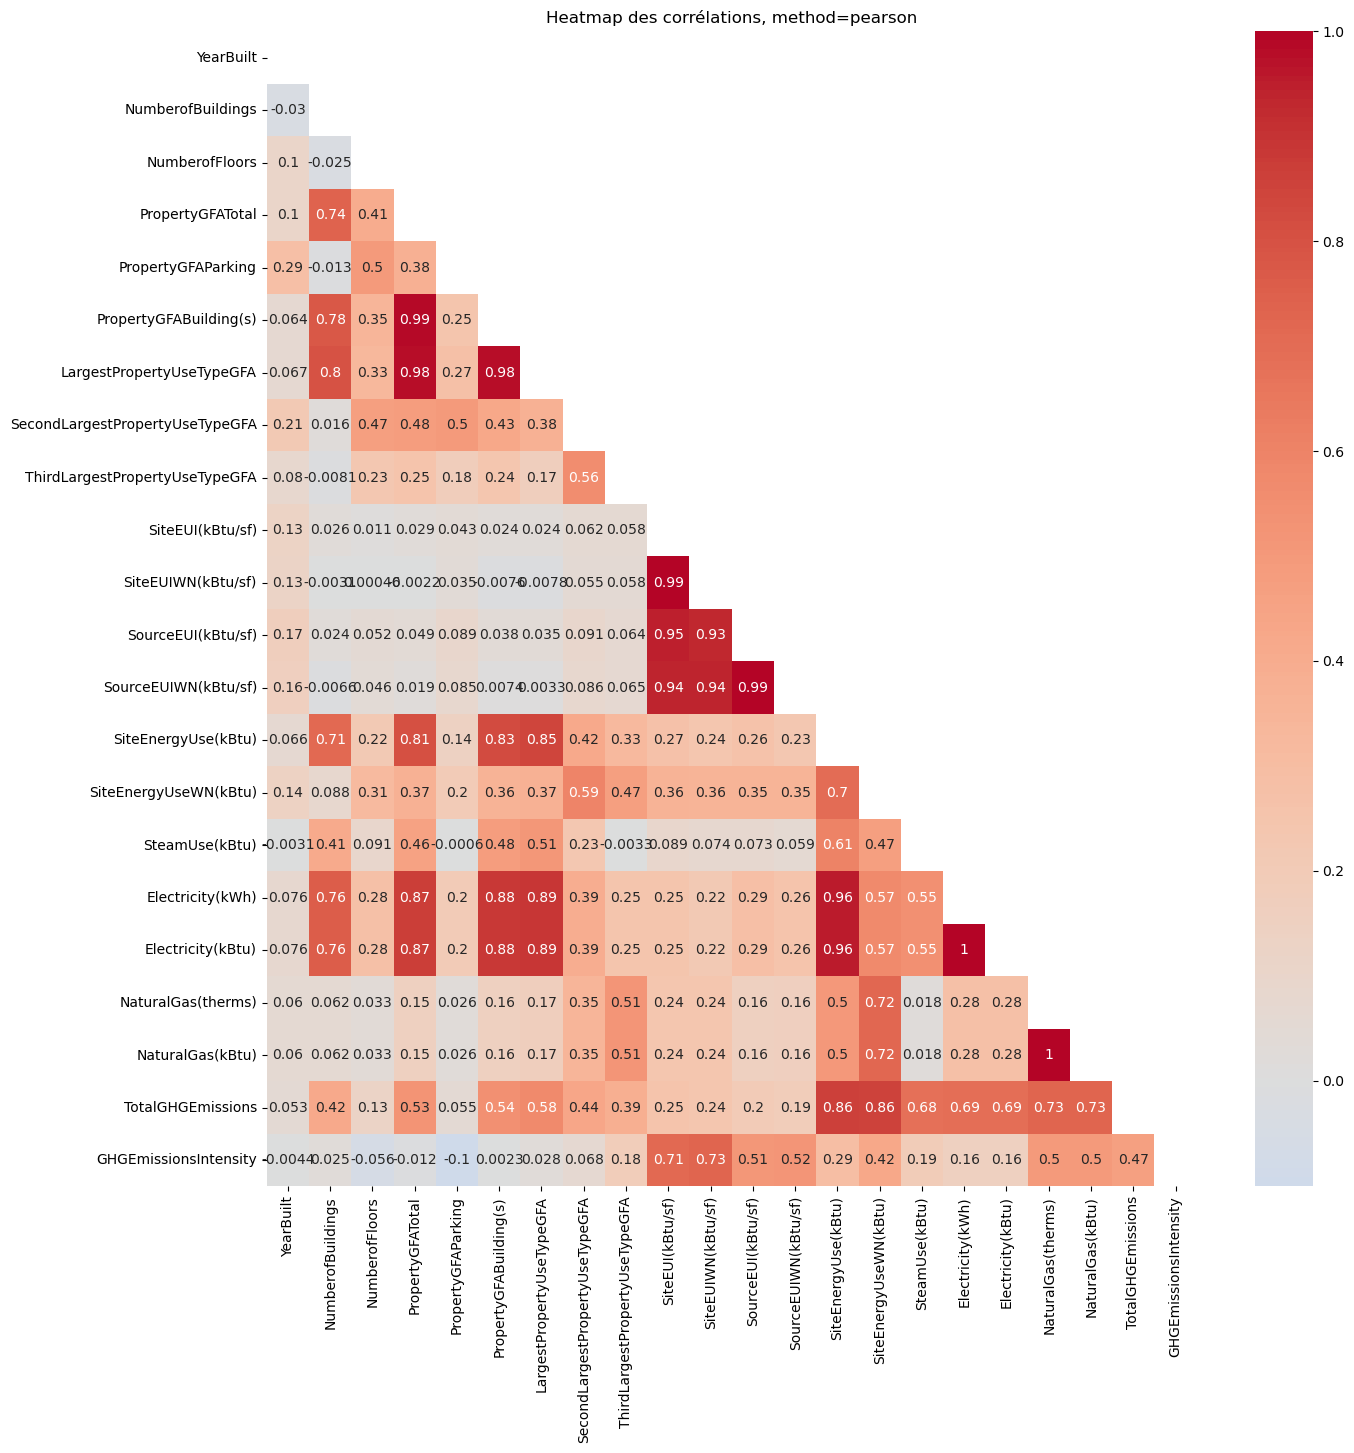

In [25]:
corr = building_data.corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(corr, annot=True, mask=mask, center=0, cmap="coolwarm")
plt.title('Heatmap des corrélations, method=pearson')
plt.show()

In [26]:
#Let's drop the collumns that are explaining the same value in a different way we will keep theWN values and the kBtu
#The SourceEUI will also go completly as the SiteEUI is more intresting for feature engeenering if needed

columns_to_drop = ['SiteEUIWN(kBtu/sf)','SourceEUIWN(kBtu/sf)','SiteEnergyUseWN(kBtu)','NaturalGas(therms)','GHGEmissionsIntensity','Electricity(kWh)','SourceEUI(kBtu/sf)']
building_data.drop(columns=columns_to_drop, inplace=True)
building_data.shape

(1540, 20)

In [27]:
#Let's also change the year to a building age 
current_year = datetime.datetime.now().year
building_data['BuildingAge'] = current_year - building_data['YearBuilt']
building_data = building_data.drop('YearBuilt', axis=1)

In [28]:
#We now have our base Dataframe to start doing some feature work our target are TotalGHGEmissions and SiteEnergyUse(kBtu)

print(building_data.head().to_string())

  PrimaryPropertyType Neighborhood  NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s) LargestPropertyUseType  LargestPropertyUseTypeGFA SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  SiteEUI(kBtu/sf)  SiteEnergyUse(kBtu)  SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  BuildingAge
0               Hotel     DOWNTOWN                1.0              12             88434                   0                   88434                  Hotel                    88434.0                         none                              0.0                        none                             0.0         81.699997            7226362.5      2003882.00          3946027.0         1276453.0             249.98           96
1               Hotel     DOWNTOWN                1.0              11            103566               15064                   88502             

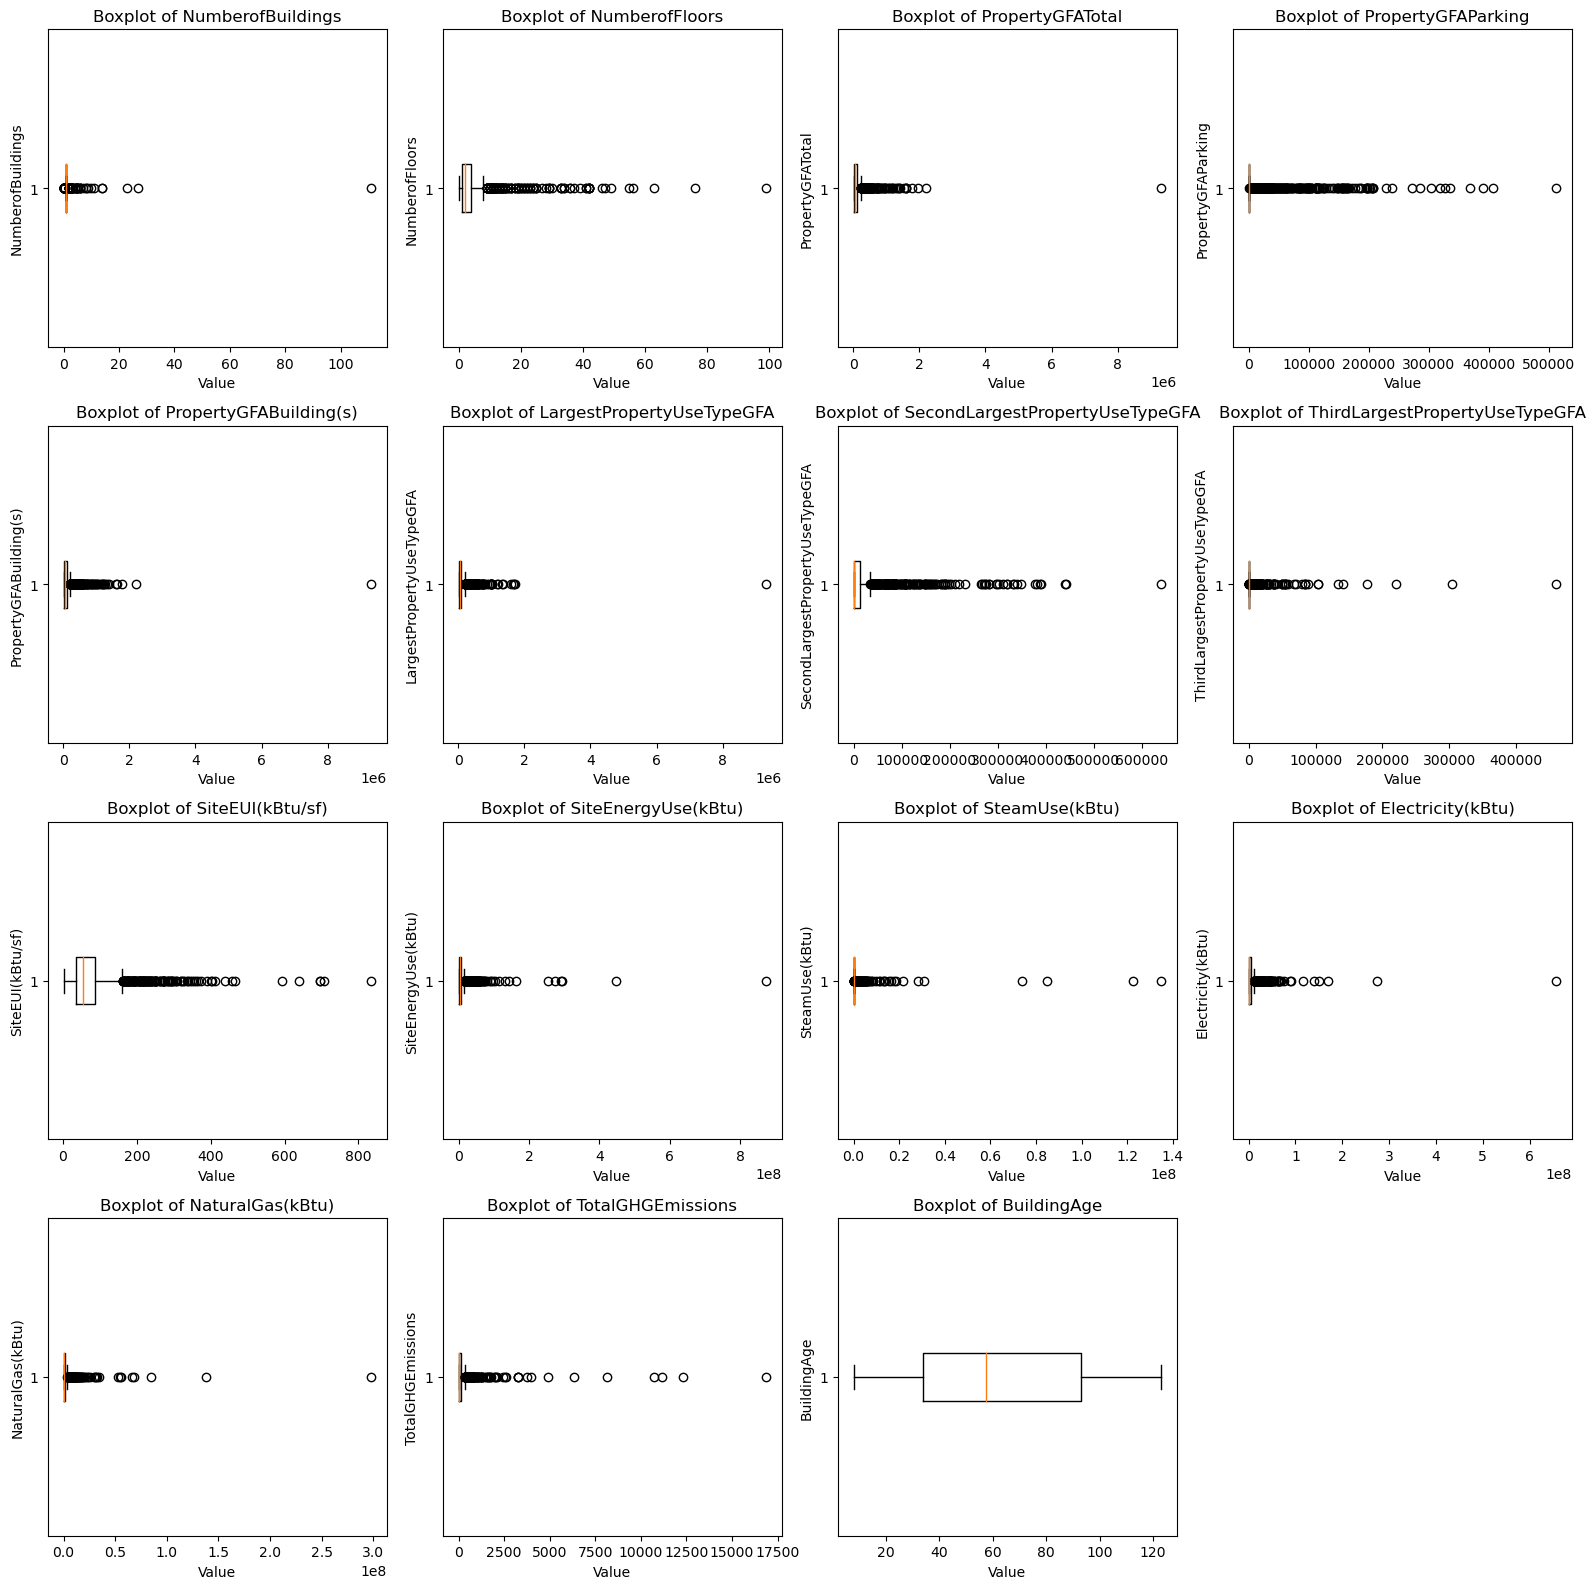

In [29]:
# Proportion du parking dans le GFA total
# eventail énergétique 
numeric_columns = building_data.select_dtypes(include='number')
columns = numeric_columns.columns

num_plots = len(columns)
num_rows = (num_plots + 3) // 4  # Calculate the number of rows

fig, axs = plt.subplots(num_rows, 4, figsize=(16, num_rows * 4))
axs = axs.flatten()  # Flatten the subplot array

for i, column in enumerate(columns):
    ax = axs[i]  # Select the current subplot
    ax.boxplot(numeric_columns[column].values, vert=False)
    ax.set_title(f"Boxplot of {column}")
    ax.set_xlabel("Value")
    ax.set_ylabel(column)

# Hide empty subplots
for j in range(i + 1, num_rows * 4):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [30]:
#One group of building seems a bit too far from everything else let's just remove it
building_data = building_data[~(building_data['NumberofBuildings']>100)]

**Lets add 3 column that explain the % of use of each energy in this building**

**Let's also add one for the % of the GFA is from parking**

In [31]:
building_data['NaturalGas_Percentage'] = building_data['NaturalGas(kBtu)'] / building_data['SiteEnergyUse(kBtu)'] * 100
building_data['Electricity_Percentage'] = building_data['Electricity(kBtu)'] / building_data['SiteEnergyUse(kBtu)'] * 100
building_data['SteamUse_Percentage'] = building_data['SteamUse(kBtu)'] / building_data['SiteEnergyUse(kBtu)'] * 100


building_data['ParkingGFA_Percentage'] = building_data['PropertyGFAParking'] / building_data['PropertyGFATotal'] * 100

building_data.shape

(1539, 24)

**Let's now create 2 main df for the model, one with some energy data from the neigborhood required, one with no data needed**

In [32]:
building_data_energy = building_data.drop(columns=['NaturalGas(kBtu)', 'Electricity(kBtu)','SteamUse(kBtu)'])

building_data_clean = building_data.drop(columns=['NaturalGas(kBtu)', 'Electricity(kBtu)','SteamUse(kBtu)','SiteEUI(kBtu/sf)'])

In [33]:
# For the energy, let's group the data by Neighborhood, and use the SiteEUI(kBtu/sf) to have a mean of the energy use / sf in this Neighborhood
# let's do the same for PrimaryPropertyType also
neighborhood_energy = building_data_energy.groupby('Neighborhood')['SiteEUI(kBtu/sf)'].mean().reset_index()
neighborhood_energy = neighborhood_energy.rename(columns={'SiteEUI(kBtu/sf)': 'MeanEnergyUsePerSF'})

mapping = dict(zip(neighborhood_energy['Neighborhood'], neighborhood_energy['MeanEnergyUsePerSF']))

building_data_energy['Neighborhood_EUI/SF'] = building_data_energy['Neighborhood'].map(mapping)


PrimaryPropertyType_energy = building_data_energy.groupby('PrimaryPropertyType')['SiteEUI(kBtu/sf)'].mean().reset_index()
PrimaryPropertyType_energy = PrimaryPropertyType_energy.rename(columns={'SiteEUI(kBtu/sf)': 'PrimaryPropertyType_EUI/SF'})

mapping = dict(zip(PrimaryPropertyType_energy['PrimaryPropertyType'], PrimaryPropertyType_energy['PrimaryPropertyType_EUI/SF']))

building_data_energy['PrimaryPropertyType_EUI/SF'] = building_data_energy['PrimaryPropertyType'].map(mapping)


#We can now drop 'SiteEUI(kBtu/sf)'
building_data_energy = building_data_energy.drop(columns=['SiteEUI(kBtu/sf)'])

In [34]:
print(building_data_energy.head().to_string())

  PrimaryPropertyType Neighborhood  NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s) LargestPropertyUseType  LargestPropertyUseTypeGFA SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  SiteEnergyUse(kBtu)  TotalGHGEmissions  BuildingAge  NaturalGas_Percentage  Electricity_Percentage  SteamUse_Percentage  ParkingGFA_Percentage  Neighborhood_EUI/SF  PrimaryPropertyType_EUI/SF
0               Hotel     DOWNTOWN                1.0              12             88434                   0                   88434                  Hotel                    88434.0                         none                              0.0                        none                             0.0            7226362.5             249.98           96              17.663838               54.605993            27.730162               0.000000             74.60317                   81.906757
1     

**Here we explore the need to transform the data with a log for example**

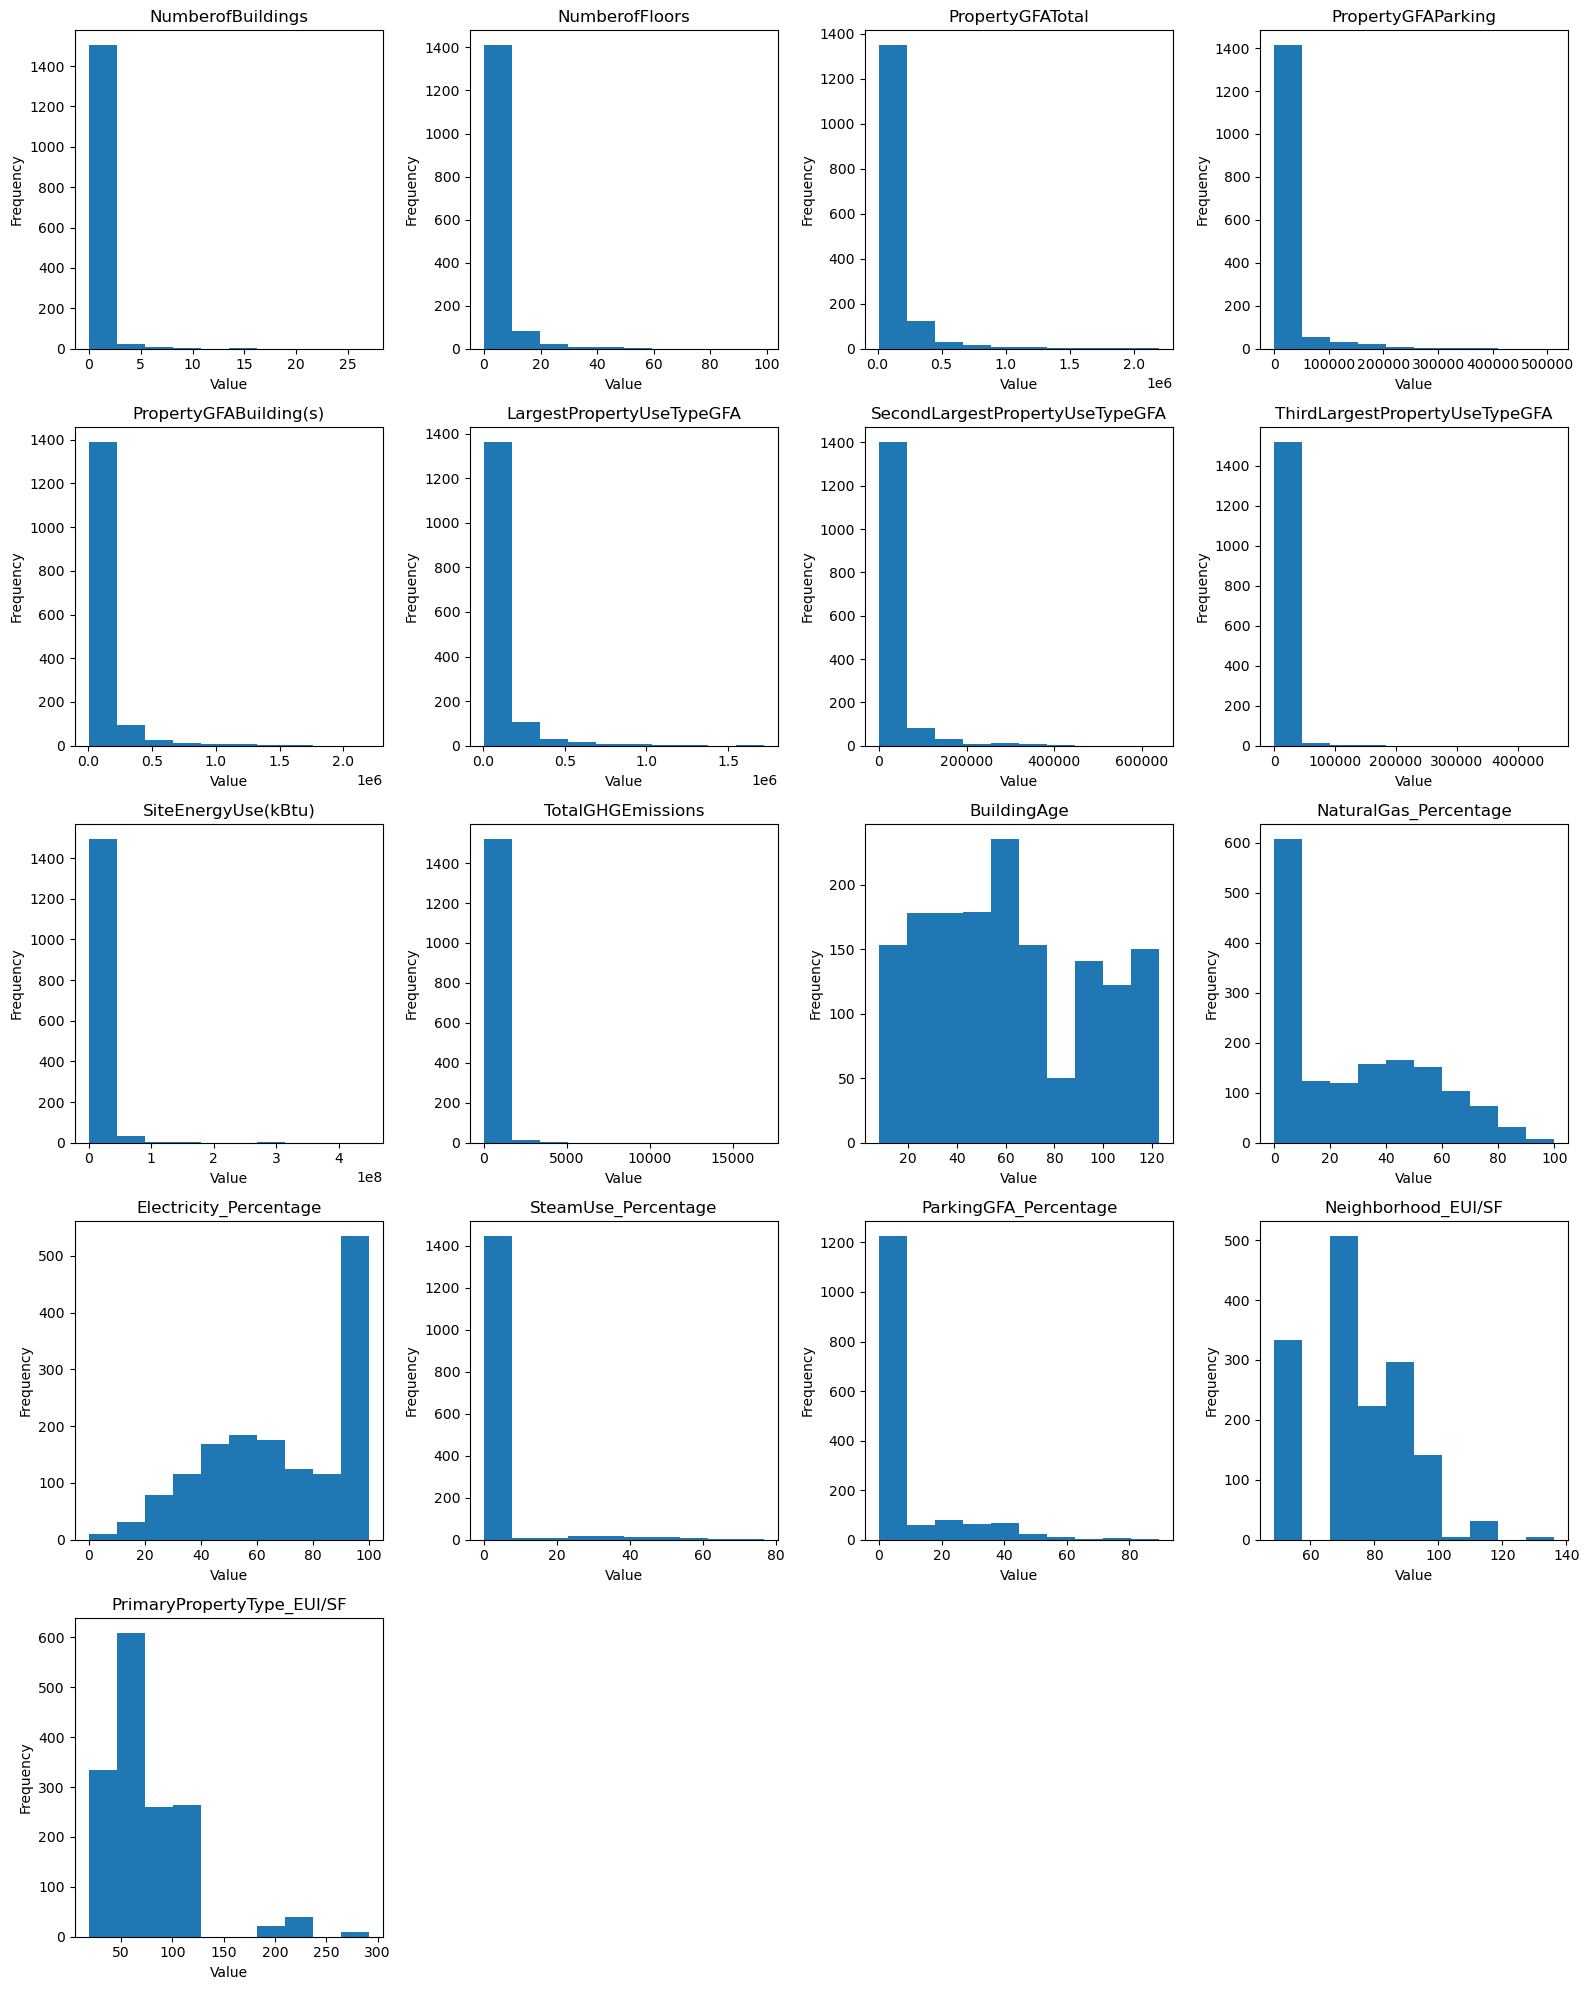

In [35]:
numeric_columns = building_data_energy.select_dtypes(include='number')
columns = numeric_columns.columns

num_plots = len(columns)
num_rows = (num_plots + 3) // 4  # Calculate the number of rows

fig, axs = plt.subplots(num_rows, 4, figsize=(16, num_rows * 4))
axs = axs.flatten()  # Flatten the subplot array

for i, column in enumerate(columns):
    ax = axs[i]  # Select the current subplot
    ax.hist(numeric_columns[column].values, bins=10)
    ax.set_title(column)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

# Hide empty subplots
for j in range(i + 1, num_rows * 4):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

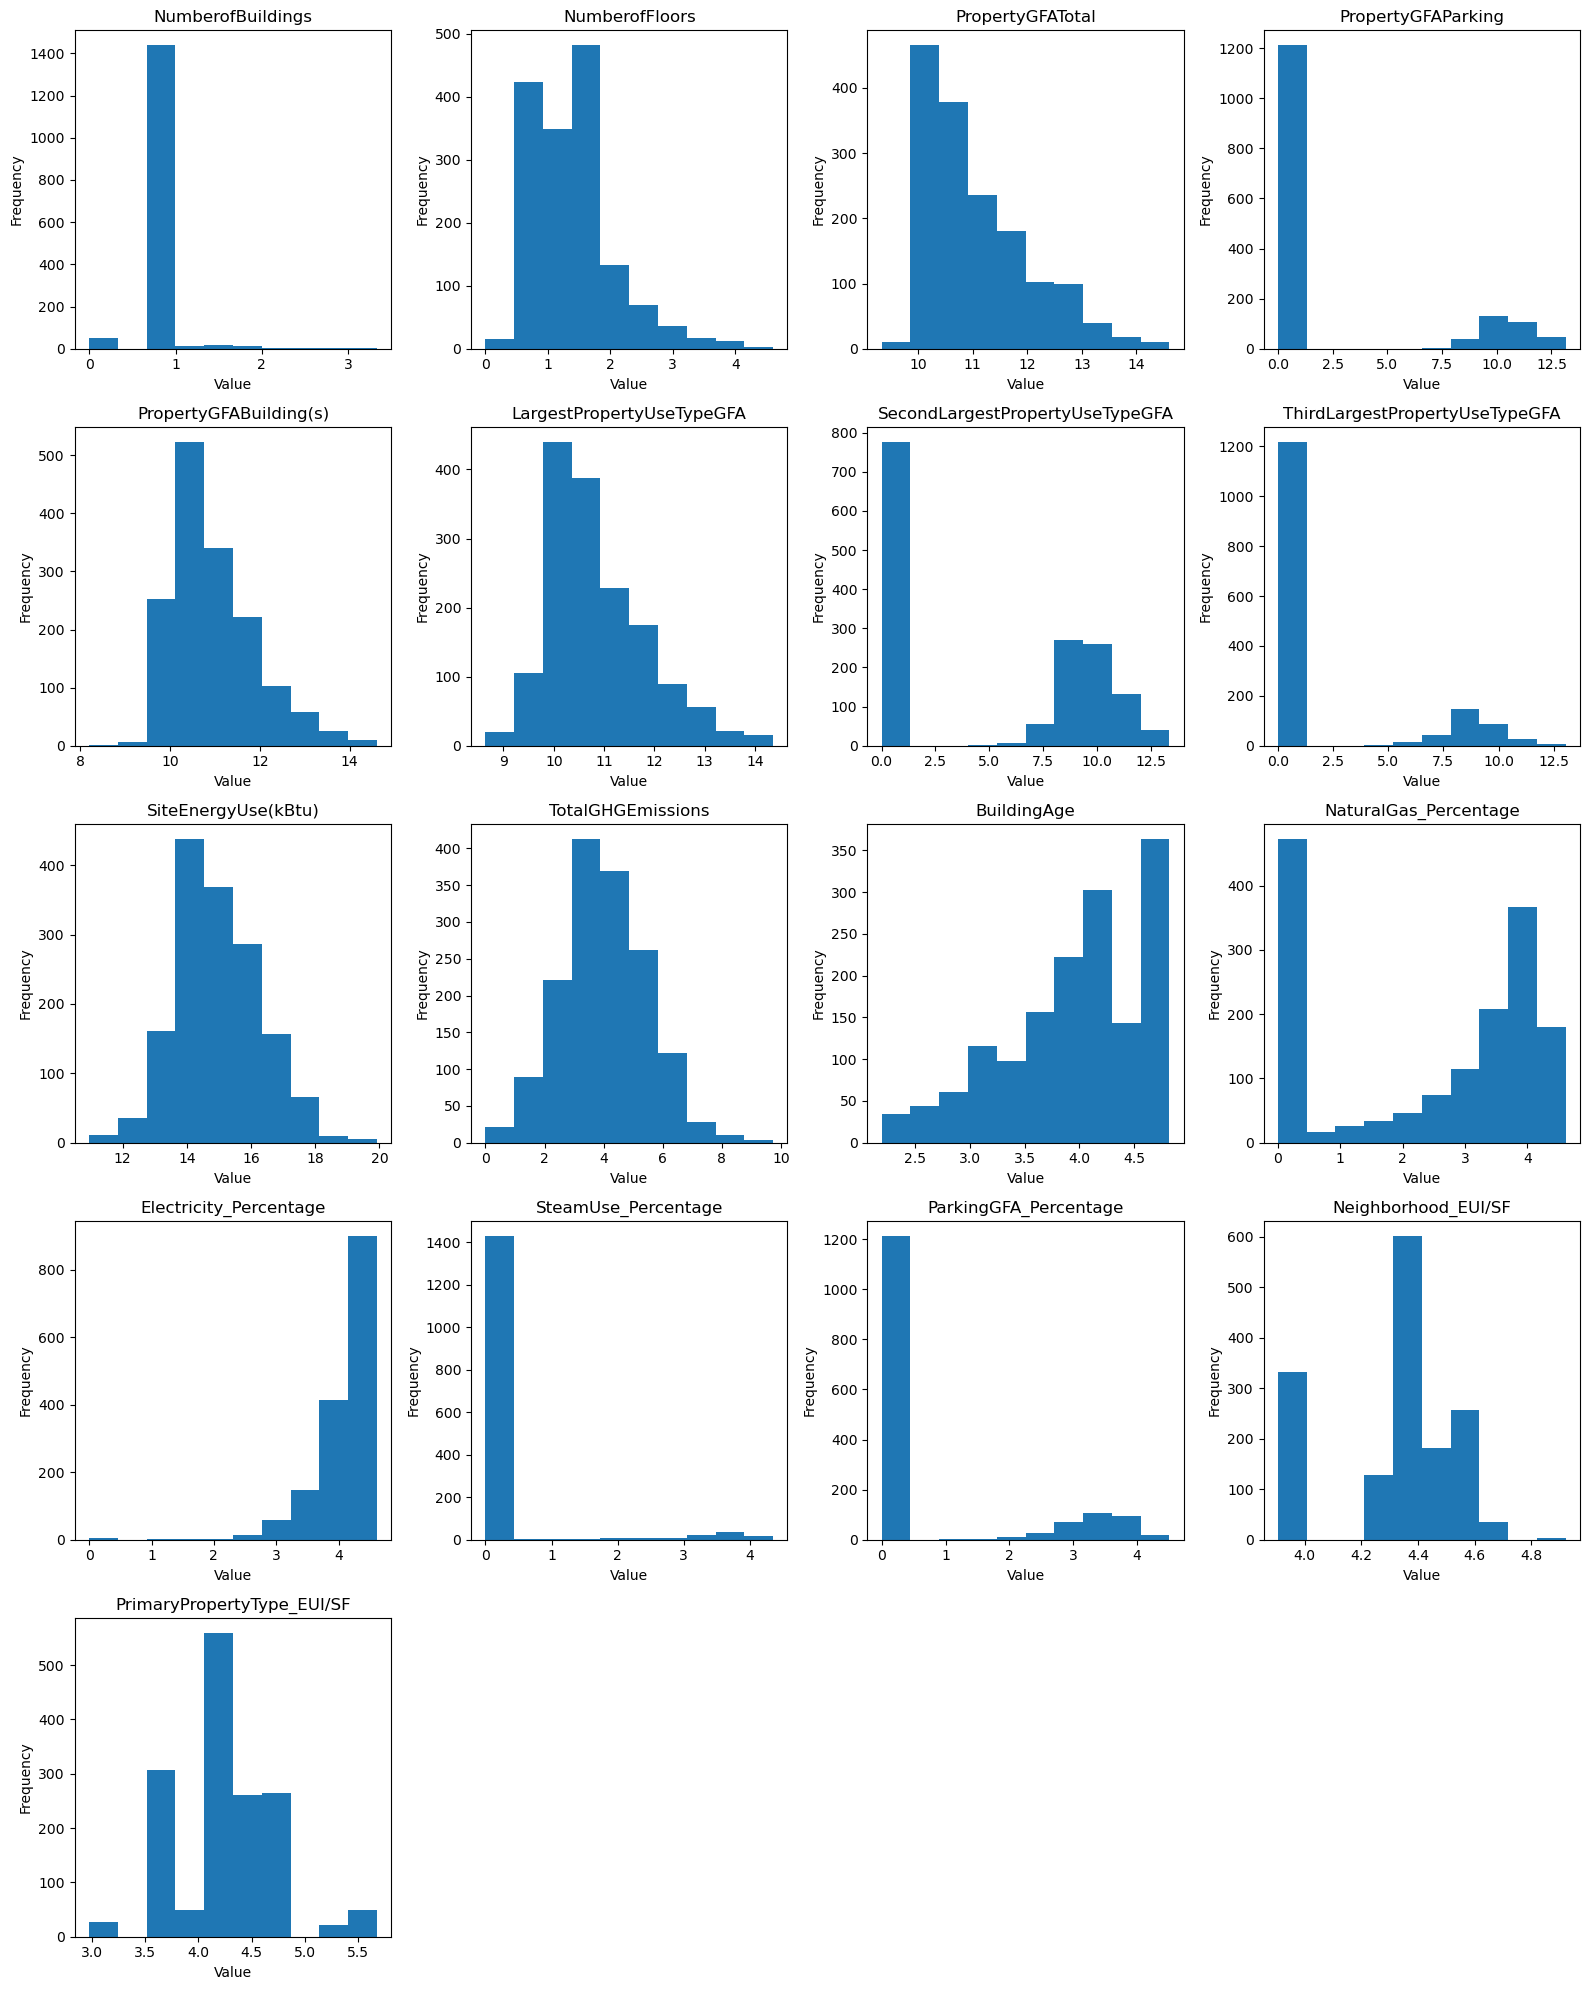

In [36]:
numeric_columns = building_data_energy.select_dtypes(include='number')
columns = numeric_columns.columns

num_plots = len(columns)
num_rows = (num_plots + 3) // 4  # Calculate the number of rows

fig, axs = plt.subplots(num_rows, 4, figsize=(16, num_rows * 4))
axs = axs.flatten()  # Flatten the subplot array

for i, column in enumerate(columns):
    ax = axs[i]  # Select the current subplot
    transformed_values = np.log1p(numeric_columns[column].values)  # Logarithm transformation
    ax.hist(transformed_values, bins=10)
    ax.set_title(f"{column}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

# Hide empty subplots
for j in range(i + 1, num_rows * 4):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


**The log transformation helps most columns except for the %of energy use and the building ages**
 

In [37]:
numeric_columns = building_data_energy.select_dtypes(include=np.number).columns
numeric_columns = np.setdiff1d(numeric_columns, ['SteamUse_Percentage','Electricity_Percentage','NaturalGas_Percentage','BuildingAge'])
building_data_energy[numeric_columns] = building_data_energy[numeric_columns].apply(np.log1p)

In [41]:
#let's do the same for the clean dataframe
numeric_columns = building_data_clean.select_dtypes(include=np.number).columns
numeric_columns = np.setdiff1d(numeric_columns, ['SteamUse_Percentage','Electricity_Percentage','NaturalGas_Percentage','BuildingAge'])
building_data_clean[numeric_columns] = building_data_clean[numeric_columns].apply(np.log1p)

In [40]:
#Also just to be sure lets check if any values is 0 in our target data

print((building_data_energy['SiteEnergyUse(kBtu)']==0).sum(),(building_data_energy['TotalGHGEmissions']==0).sum())

0 1


In [42]:
building_data_energy = building_data_energy[building_data_energy['TotalGHGEmissions'] != 0]
building_data_clean = building_data_clean[building_data_clean['TotalGHGEmissions'] != 0]

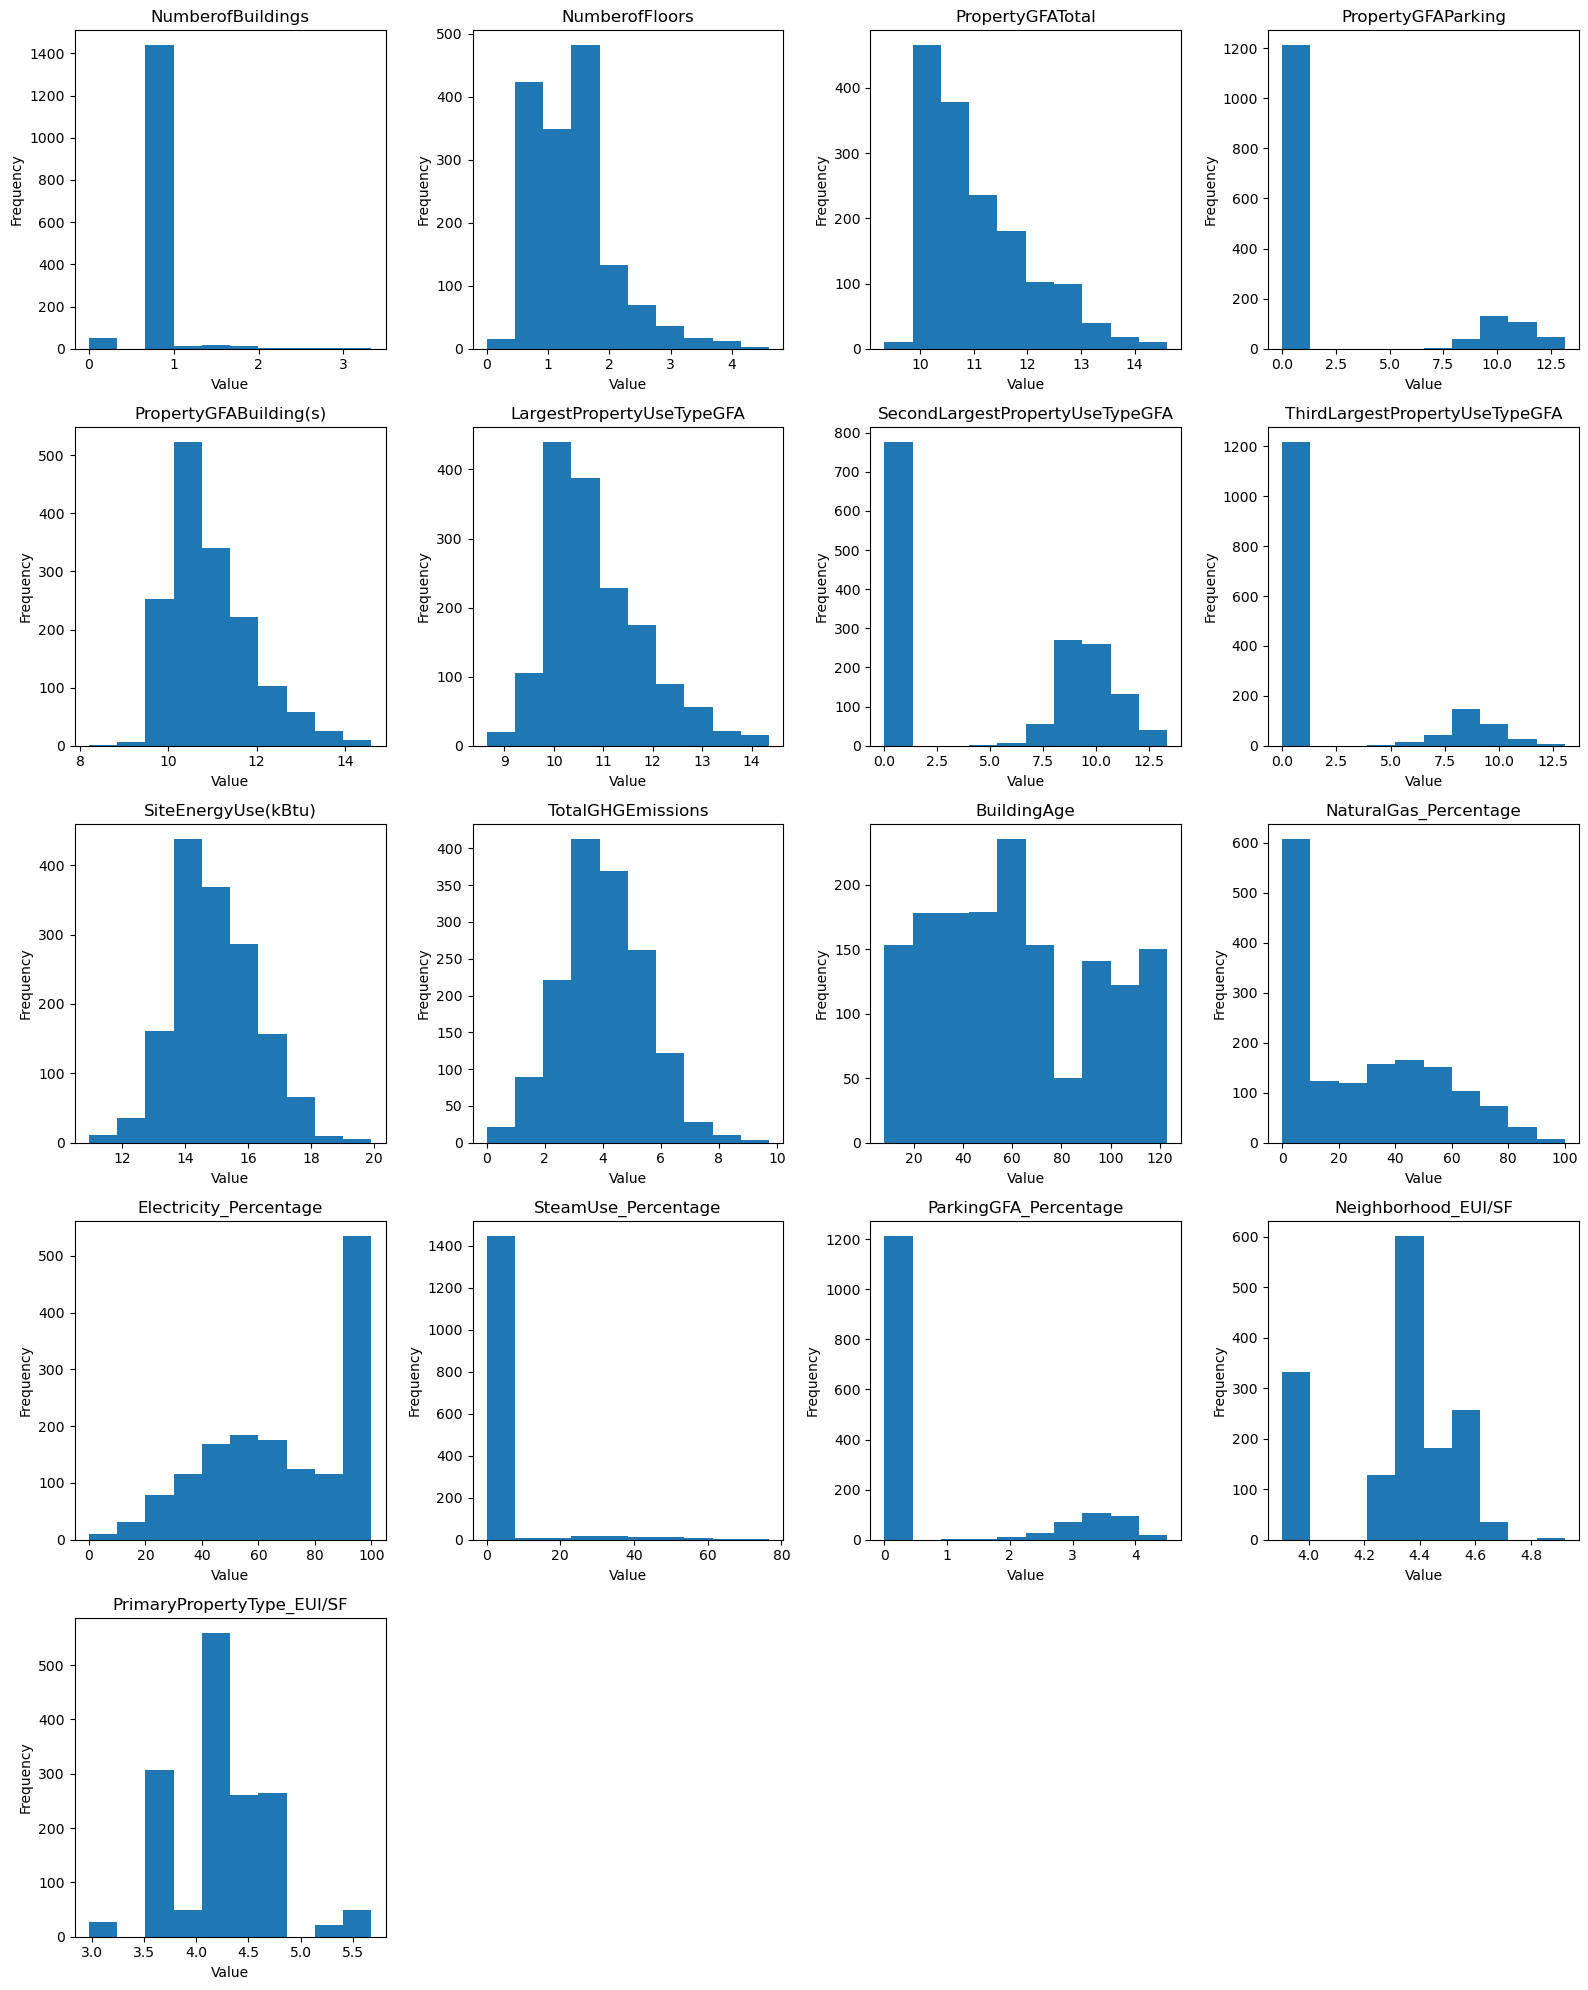

In [ ]:
numeric_columns = building_data_energy.select_dtypes(include='number')
columns = numeric_columns.columns

num_plots = len(columns)
num_rows = (num_plots + 3) // 4  # Calculate the number of rows

fig, axs = plt.subplots(num_rows, 4, figsize=(16, num_rows * 4))
axs = axs.flatten()  # Flatten the subplot array

for i, column in enumerate(columns):
    ax = axs[i]  # Select the current subplot
    transformed_values = numeric_columns[column].values  # Logarithm transformation
    ax.hist(transformed_values, bins=10)
    ax.set_title(f"{column}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

# Hide empty subplots
for j in range(i + 1, num_rows * 4):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [43]:
#That's it for our two datasets:

building_data_clean.to_csv('U://DATA/OpenClassrooms/Data science/P4/building_data_clean.csv')
building_data_energy.to_csv('U://DATA/OpenClassrooms/Data science/P4/building_data_energy.csv')
